In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, v_backtester, c_backtester, perf, perf_var
import sys
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
time_int = 60
periods = 100
multi_periods = [25, 50, 100]
multiplier = 20
threshold = 1
bankroll = 15000
smooth = int(np.ceil(periods/4))

In [3]:
contract = pd.read_pickle('data/minute_NQ_cont_non_active_included.pickle')
#contract = contract.loc['20180202':]
contract = contract.loc['20190401':]
#contract = contract.loc['20180202': '20180228']
#contract = contract.loc['20181001':'20181231']

In [4]:
#avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol = contract.volume.rolling(time_int).sum().mean()
avg_vol

12895.25307274477

In [5]:
vol_candles = group_by_volume(contract, avg_vol)
#vol_candles['atr'] = get_ATR(vol_candles, atr_periods)
vol_candles

,date,open,high,low,close,barCount,volume
label,,,,,,,
0,2019-04-01 03:05:00,1297.2,1298.3,1294.8,1297.4,5177,12844
1,2019-04-01 05:22:00,1297.5,1298.3,1296.2,1298.1,5590,12992
2,2019-04-01 08:21:00,1298.0,1298.5,1294.9,1295.1,5494,12934
3,2019-04-01 09:10:00,1295.0,1295.1,1292.6,1293.1,4877,13434
4,2019-04-01 10:36:00,1293.1,1295.9,1292.8,1295.3,5223,13161
...,...,...,...,...,...,...,...
2504,2019-09-05 16:46:00,1525.2,1526.2,1523.6,1524.1,5298,12786
2505,2019-09-05 16:57:00,1524.2,1525.0,1521.9,1522.5,5288,13192
2506,2019-09-05 17:08:00,1522.6,1525.1,1520.3,1524.6,4886,12046


In [6]:
data = pd.DataFrame({'date': vol_candles.date,
                     'open': vol_candles.open,
                     'close': vol_candles.close})

In [7]:
data['change'] = data.close.diff().fillna(0)
data['up'] = (data['change'] > 0) * data['change']
data['down'] = ((data['change'] < 0) * data['change']).abs()
data

,date,open,close,change,up,down
label,,,,,,
0,2019-04-01 03:05:00,1297.2,1297.4,0.0,0.0,0.0
1,2019-04-01 05:22:00,1297.5,1298.1,0.7,0.7,0.0
2,2019-04-01 08:21:00,1298.0,1295.1,-3.0,-0.0,3.0
3,2019-04-01 09:10:00,1295.0,1293.1,-2.0,-0.0,2.0
4,2019-04-01 10:36:00,1293.1,1295.3,2.2,2.2,0.0
...,...,...,...,...,...,...
2504,2019-09-05 16:46:00,1525.2,1524.1,-1.1,-0.0,1.1
2505,2019-09-05 16:57:00,1524.2,1522.5,-1.6,-0.0,1.6
2506,2019-09-05 17:08:00,1522.6,1524.6,2.1,2.1,0.0


In [8]:
data['rs'] = data['up'].ewm(span=periods, min_periods=periods*.9).mean() / data['down'].ewm(span=periods, min_periods=periods*.9).mean()
data['rsi'] = (100 - (100 / (1 + data['rs'])))
data['rsi_mod'] = data['rsi'] - 50
data['rsi_mod'] *= -1.3
data['rsi_mod'] = data['rsi_mod'].clip(lower=-20, upper=20)
data

,date,open,close,change,up,down,rs,rsi,rsi_mod
label,,,,,,,,,
0,2019-04-01 03:05:00,1297.2,1297.4,0.0,0.0,0.0,NaN,NaN,NaN
1,2019-04-01 05:22:00,1297.5,1298.1,0.7,0.7,0.0,NaN,NaN,NaN
2,2019-04-01 08:21:00,1298.0,1295.1,-3.0,-0.0,3.0,NaN,NaN,NaN
3,2019-04-01 09:10:00,1295.0,1293.1,-2.0,-0.0,2.0,NaN,NaN,NaN
4,2019-04-01 10:36:00,1293.1,1295.3,2.2,2.2,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2504,2019-09-05 16:46:00,1525.2,1524.1,-1.1,-0.0,1.1,0.660616,-10.218612,20.0
2505,2019-09-05 16:57:00,1524.2,1522.5,-1.6,-0.0,1.6,0.643628,-10.841031,20.0
2506,2019-09-05 17:08:00,1522.6,1524.6,2.1,2.1,0.0,0.678062,-9.592555,20.0


In [9]:
10/data['rsi_mod'].abs().mean()

0.5

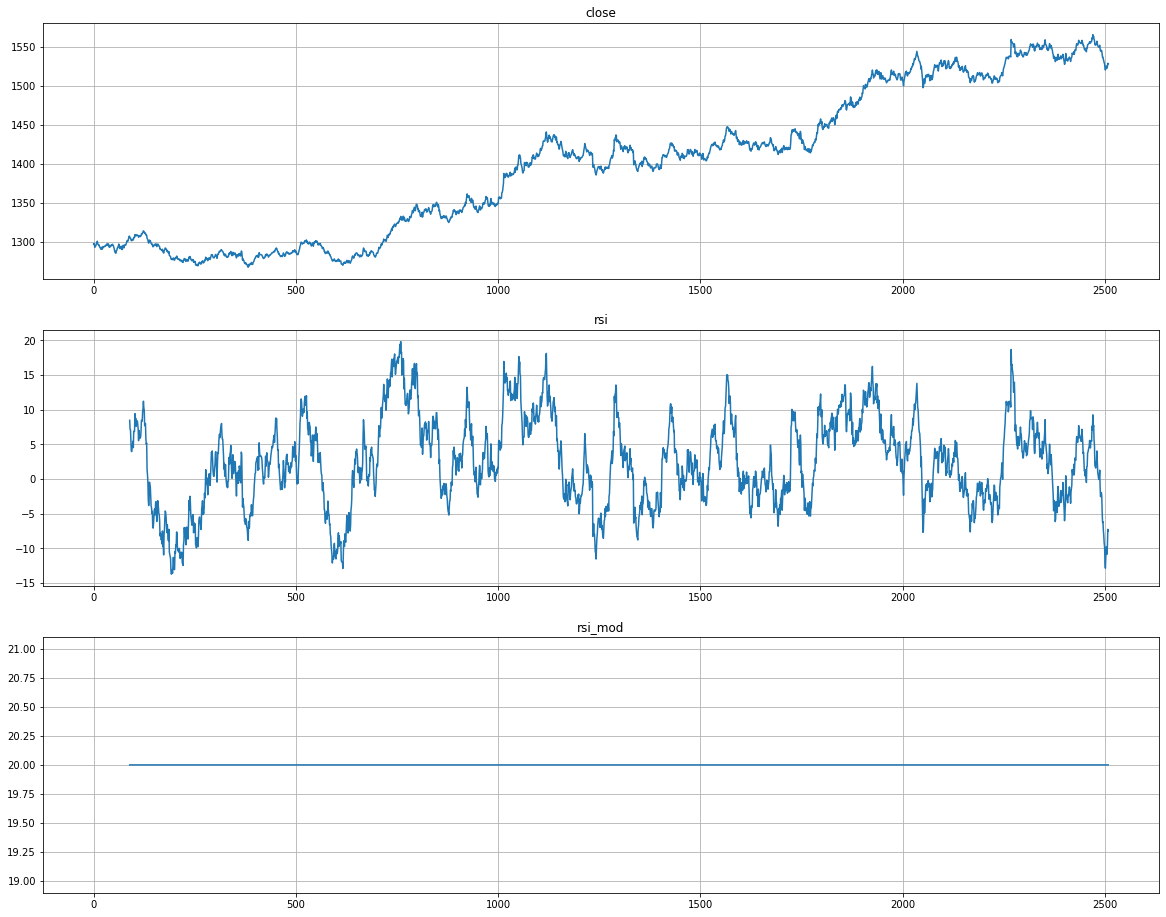

In [10]:
plot(data[['close', 'rsi', 'rsi_mod']])

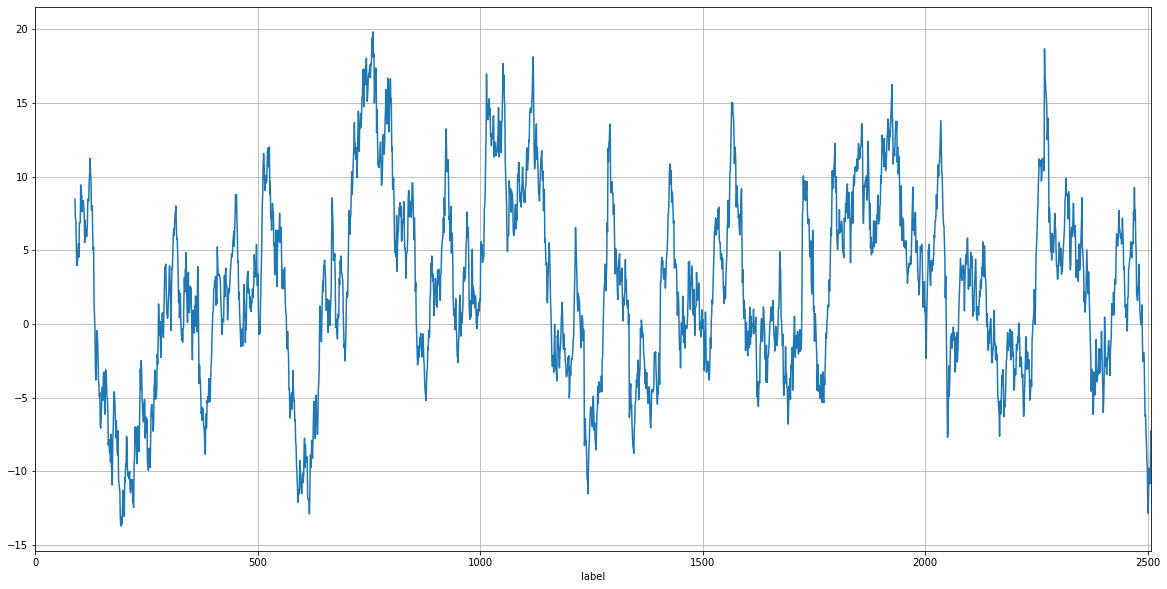

In [11]:
data['rsi'].plot(figsize=(20,10), grid=True);

In [12]:
data['rsi_shift'] = (data['rsi'] - 50) / 20
data

,date,open,close,change,up,down,rs,rsi,rsi_mod,rsi_shift
label,,,,,,,,,,
0,2019-04-01 03:05:00,1297.2,1297.4,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,2019-04-01 05:22:00,1297.5,1298.1,0.7,0.7,0.0,NaN,NaN,NaN,NaN
2,2019-04-01 08:21:00,1298.0,1295.1,-3.0,-0.0,3.0,NaN,NaN,NaN,NaN
3,2019-04-01 09:10:00,1295.0,1293.1,-2.0,-0.0,2.0,NaN,NaN,NaN,NaN
4,2019-04-01 10:36:00,1293.1,1295.3,2.2,2.2,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2504,2019-09-05 16:46:00,1525.2,1524.1,-1.1,-0.0,1.1,0.660616,-10.218612,20.0,-3.010931
2505,2019-09-05 16:57:00,1524.2,1522.5,-1.6,-0.0,1.6,0.643628,-10.841031,20.0,-3.042052
2506,2019-09-05 17:08:00,1522.6,1524.6,2.1,2.1,0.0,0.678062,-9.592555,20.0,-2.979628


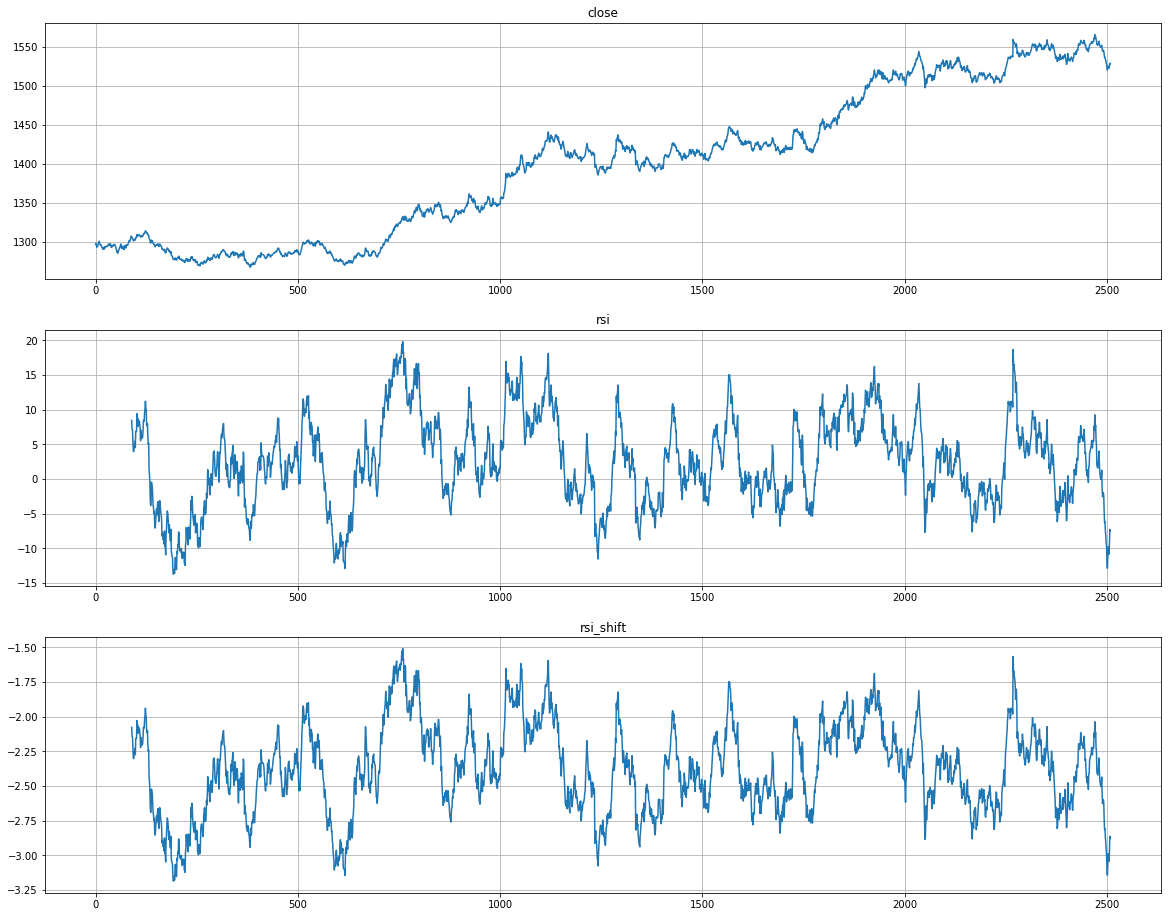

In [13]:
plot(data[['close', 'rsi', 'rsi_shift']])

In [14]:
data['rsi_shift'].abs().mean()

2.374168900248072

In [15]:
data['rsi_trans'] = np.sin(data['rsi_shift'] * np.pi)
data['trans_smooth'] = data['rsi_trans'].ewm(span=10).mean()
data.tail(20)

,date,open,close,change,up,down,rs,rsi,rsi_mod,rsi_shift,rsi_trans,trans_smooth
label,,,,,,,,,,,,
2489,2019-09-05 14:38:00,1546.9,1544.3,-2.7,-0.0,2.7,0.903561,-2.533119,20.0,-2.626656,-0.921876,-0.943646
2490,2019-09-05 14:52:00,1544.4,1545.2,0.9,0.9,0.0,0.921172,-2.051551,20.0,-2.602578,-0.948523,-0.944533
2491,2019-09-05 15:12:00,1545.3,1545.4,0.2,0.2,0.0,0.925165,-1.943599,20.0,-2.597180,-0.953757,-0.946210
2492,2019-09-05 15:35:00,1545.5,1544.5,-0.9,-0.0,0.9,0.908512,-2.396842,20.0,-2.619842,-0.929959,-0.943255
2493,2019-09-05 15:41:00,1544.4,1539.8,-4.7,-0.0,4.7,0.829010,-4.674377,20.0,-2.733719,-0.742334,-0.906724
2494,2019-09-05 15:49:00,1539.8,1536.3,-3.5,-0.0,3.5,0.777332,-6.264107,20.0,-2.813205,-0.553726,-0.842543
2495,2019-09-05 15:59:00,1536.3,1536.5,0.2,0.2,0.0,0.780966,-6.149299,20.0,-2.807465,-0.568652,-0.792744
2496,2019-09-05 16:04:00,1536.5,1533.6,-2.9,-0.0,2.9,0.741124,-7.434160,20.0,-2.871708,-0.392218,-0.719921
2497,2019-09-05 16:09:00,1533.6,1532.1,-1.5,-0.0,1.5,0.721695,-8.082282,20.0,-2.904114,-0.296699,-0.642972


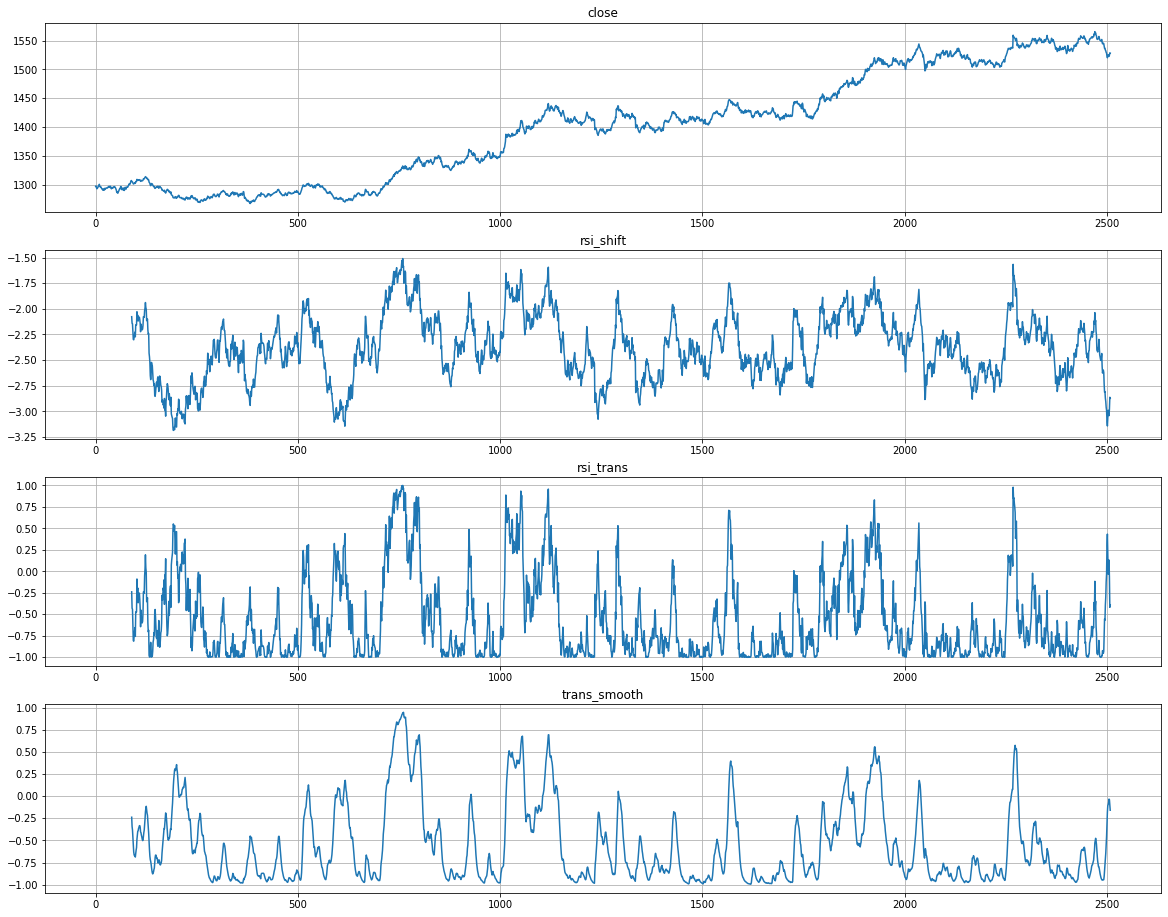

In [16]:
plot(data['close'], data['rsi_shift'], data['rsi_trans'], data['trans_smooth'])

In [17]:
data[['close', 'rsi', 'rsi_shift', 'rsi_trans']].loc[43:].head(30)

,close,rsi,rsi_shift,rsi_trans
label,,,,
43,1295.9,NaN,NaN,NaN
44,1295.1,NaN,NaN,NaN
45,1295.9,NaN,NaN,NaN
46,1296.9,NaN,NaN,NaN
47,1296.8,NaN,NaN,NaN
48,1295.7,NaN,NaN,NaN
49,1294.6,NaN,NaN,NaN
50,1292.8,NaN,NaN,NaN
51,1290.9,NaN,NaN,NaN


In [18]:
signal = pd.DataFrame({'close': data.close,
                     'rsi': data.rsi})
signal = signal.loc[45:]
signal

,close,rsi
label,,
45,1295.9,NaN
46,1296.9,NaN
47,1296.8,NaN
48,1295.7,NaN
49,1294.6,NaN
...,...,...
2504,1524.1,-10.218612
2505,1522.5,-10.841031
2506,1524.6,-9.592555


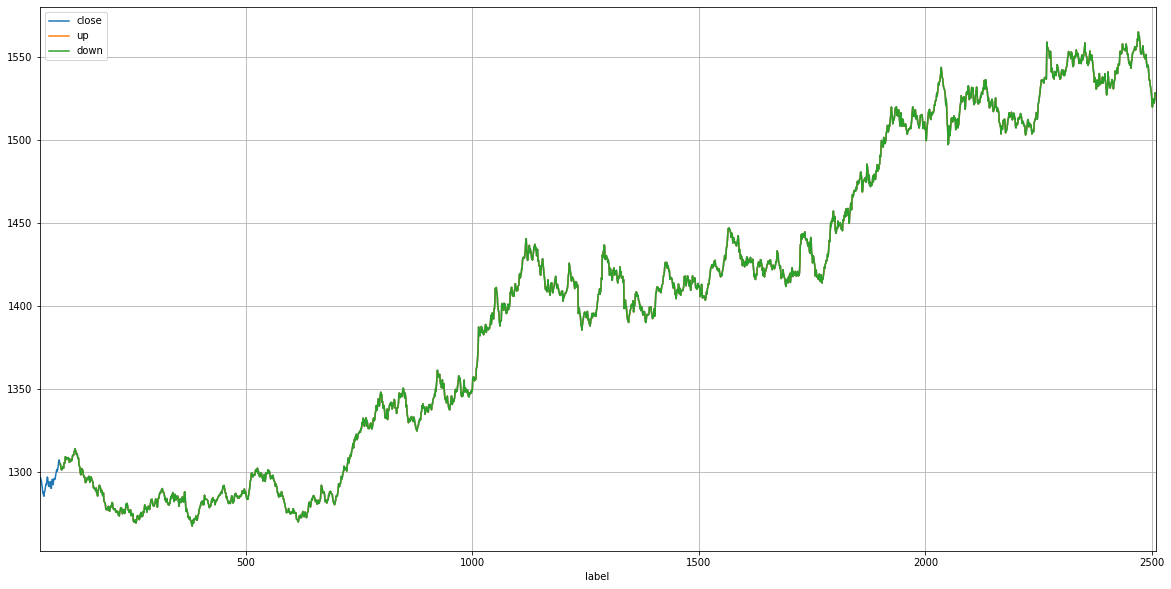

In [19]:
signal['up'] = ((signal['rsi'] > 50) | (signal['rsi'] < 40)).shift() * signal['close']
signal['down'] = ((signal['rsi'] < 50) | (signal['rsi']> 60)).shift() * signal['close']
signal['up'] = signal['up'].replace(0, np.nan)
signal['down'] = signal['down'].replace(0, np.nan)
signal[['close', 'up', 'down']].plot(figsize=(20,10), grid=True);

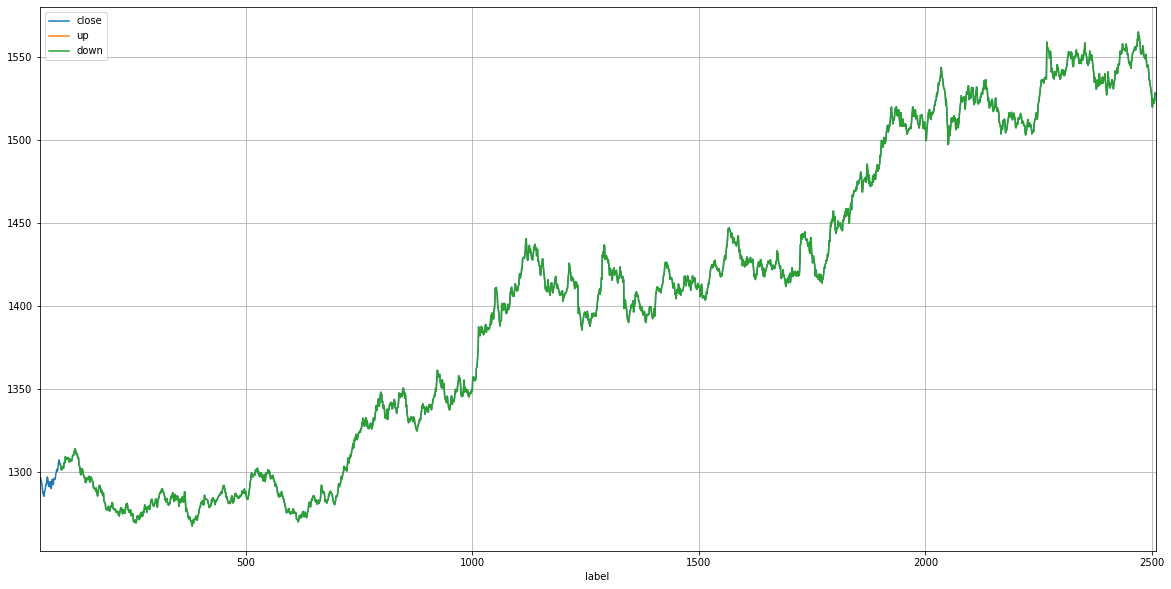

In [20]:
signal['up'] = ((signal['rsi'] > 50)).shift() * signal['close']
signal['down'] = ((signal['rsi'] < 50)).shift() * signal['close']
signal['up'] = signal['up'].replace(0, np.nan)
signal['down'] = signal['down'].replace(0, np.nan)
signal[['close', 'up', 'down']].plot(figsize=(20,10), grid=True);

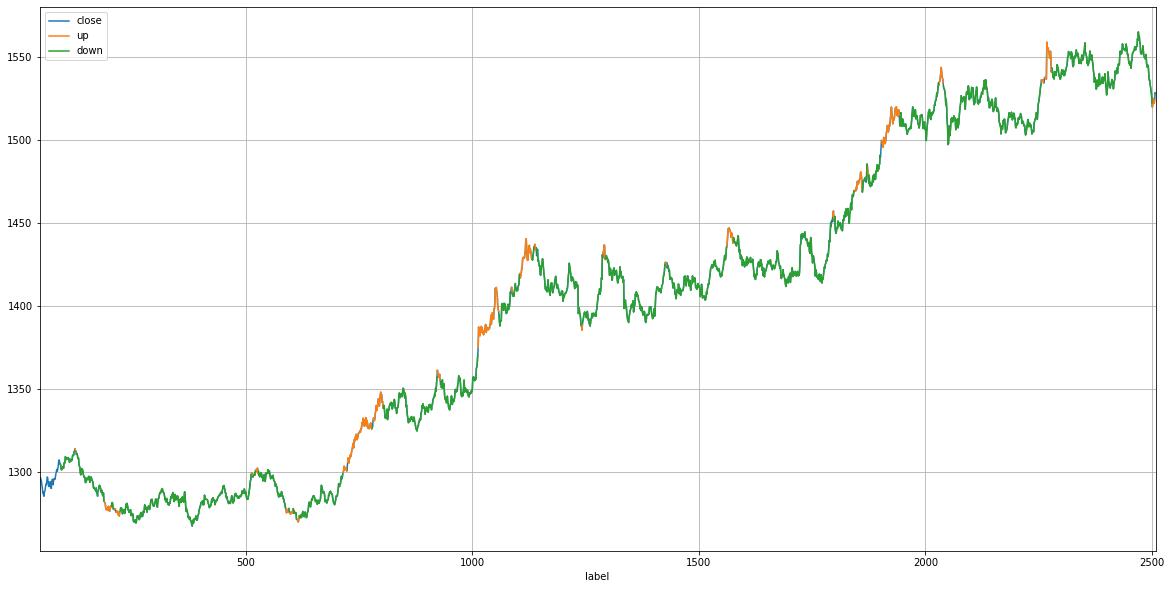

In [21]:
signal_1 = pd.DataFrame({'close': data.close,
                         'rsi_trans': data.rsi_trans})
signal_1 = signal_1.loc[45:]
signal_1['up'] = ((signal_1['rsi_trans'] > 0)).shift() * signal_1['close']
signal_1['down'] = ((signal_1['rsi_trans'] < 0)).shift() * signal_1['close']
signal_1['up'] = signal_1['up'].replace(0, np.nan)
signal_1['down'] = signal_1['down'].replace(0, np.nan)
signal_1[['close', 'up', 'down']].plot(figsize=(20,10), grid=True);

In [22]:
data = data[90:]

In [23]:
test_data = data[['date', 'close', 'rsi']]

In [24]:
test_data['signal_up'] = (test_data['rsi'] >= 50) * 1
test_data['signal_down'] = (test_data['rsi'] < 50) * -1
test_data['signal'] = test_data['signal_up'] + test_data['signal_down']
test_data = test_data.iloc[50:]
test_data['position'] = test_data['signal'].shift().fillna(0)
test_data.set_index('date', inplace=True)
test_data.head()

,close,rsi,signal_up,signal_down,signal,position
date,,,,,,
2019-04-11 16:23:00,1301.5,-1.113564,0,-1,-1,0.0
2019-04-11 16:59:00,1299.9,-2.430747,0,-1,-1,-1.0
2019-04-11 17:26:00,1298.1,-3.857655,0,-1,-1,-1.0
2019-04-11 17:46:00,1297.7,-4.169329,0,-1,-1,-1.0
2019-04-11 18:19:00,1296.7,-4.945512,0,-1,-1,-1.0


Annual return                   -0.365071
Cumulative returns              -0.175413
Annual volatility                0.160077
Sharpe ratio                     -2.75571
Calmar ratio                     -1.66811
Stability                        0.918281
Max drawdown                    -0.218853
Omega ratio                      0.617014
Sortino ratio                    -3.45007
Skew                             0.112132
Kurtosis                          1.12992
Tail ratio                       0.740691
Daily value at risk            -0.0219183
Win percent                             0
Average gain                          NaN
Average loss                       -228.3
Avg gain/loss ratio                   NaN
Position EV                           NaN
Positions per day              0.00934579
Days per position                     107
Actual avg. duration    147 days 00:28:00
Days                                  107
Positions                               1
Trades                            

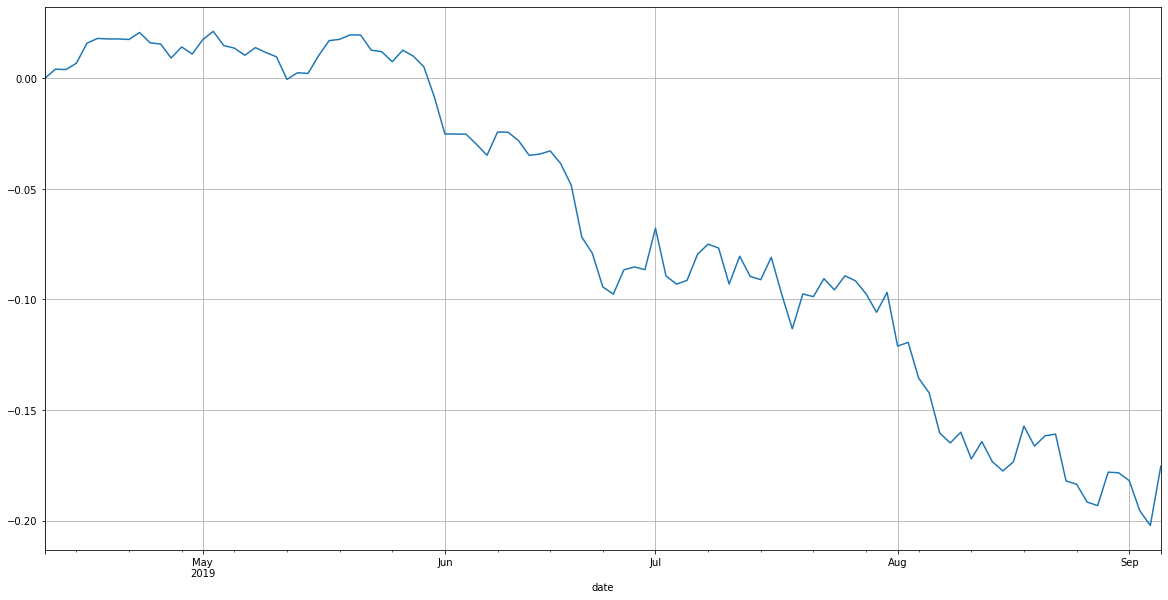

In [25]:
result = perf_var(test_data[['close', 'position']], price_column_name='close')

In [26]:
result.df.head(20)

,price,position,transaction,curr_price,base_price,pnl
date,,,,,,
2019-04-11 16:23:00,1301.5,0.0,0,0.0,0.0,0.0
2019-04-11 16:59:00,1299.9,-1.0,-1,0.0,0.0,0.0
2019-04-11 17:26:00,1298.1,-1.0,0,-1298.1,-1299.9,1.8
2019-04-11 17:46:00,1297.7,-1.0,0,-1297.7,-1298.1,0.4
2019-04-11 18:19:00,1296.7,-1.0,0,-1296.7,-1297.7,1.0
2019-04-11 19:09:00,1297.0,-1.0,0,-1297.0,-1296.7,-0.3
2019-04-11 19:25:00,1294.0,-1.0,0,-1294.0,-1297.0,3.0
2019-04-11 19:41:00,1293.8,-1.0,0,-1293.8,-1294.0,0.2
2019-04-11 21:03:00,1294.5,-1.0,0,-1294.5,-1293.8,-0.7


In [27]:
result.positions.tail(20)

,date_o,open,date_c,close,pnl,duration
0,2019-04-11 16:59:00,-1299.9,2019-09-05 17:27:00,1528.2,-228.3,147 days 00:28:00


In [28]:
a = pd.DataFrame({'x': np.arange(-4,4, .1),})
a['y'] = (1/(1+np.exp(-a['x'])))
a['z'] = (a['x'] / (1+a['x']**2)**.5)

In [29]:
a.set_index('x', inplace=True)

In [30]:
a

,y,z
x,,
-4.0,0.017986,-0.970143
-3.9,0.019840,-0.968664
-3.8,0.021881,-0.967075
-3.7,0.024127,-0.965363
-3.6,0.026597,-0.963518
...,...,...
3.5,0.970688,0.961524
3.6,0.973403,0.963518
3.7,0.975873,0.965363


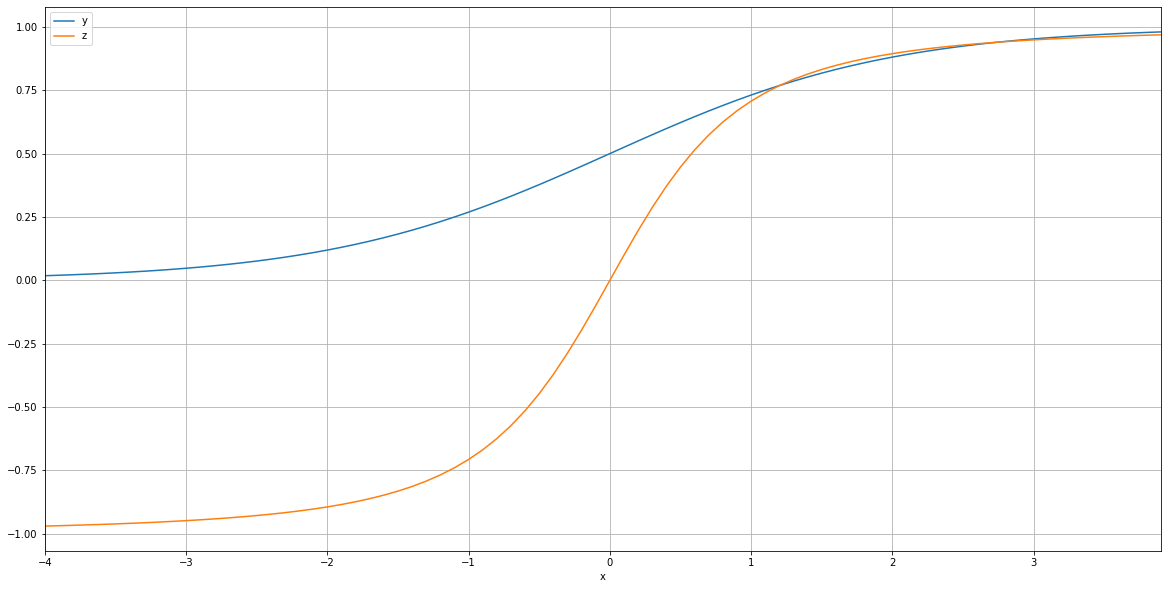

In [31]:
a.plot(figsize=(20,10), grid=True);